In [40]:
import numpy as np
import numpy.random
import scipy.stats as ss
import matplotlib.pyplot as plt
from visualize import *
from calibration import *
import torch
import GPy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import normalize
numpy.random.seed(0x5eed)
% matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
#import matplotlib;matplotlib.rcParams['text.usetex'] = True
import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

In [6]:
def gmm_sample(n, weights, norm_params, plot=False):
    """
    This function draws n samples from Gaussian mixture models parametrized by weights and 
    norm_params. Plot can only be turned on in one dimensional case.
    INPUT:
        n: An int. The number of samples to draw.
        weights: np.array (num_components,). Weights of each component.
        norm_params:
        plot: Boolean. If True, theretical PDF of the GMM and histogram of data will be plotted.
    OUTPUT:
        y: np.array (n, ). Samples drawn from GMM.
        mixture_idx: np.array (n, ). True label of each sample.
    """
    assert weights.shape[0] == norm_params.shape[0]
    assert norm_params.shape[1] == 2
    assert weights.sum() == 1.0
    assert weights.all() > 0
    if plot == True:
        assert norm_params[0,0].shape  == ()
    n_components = norm_params.shape[0]
    # Weight of each component, in this case all of them are 1/3
    # A stream of indices from which to choose the component
    mixture_idx = np.random.choice(n_components, size=n, replace=True, p=weights)
    # y is the mixture sample
    y = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                       dtype=np.float64)
    if plot:
        # Theoretical PDF plotting -- generate the x and y plotting positions
        xs = np.linspace(y.min(), y.max(), 200)
        ys = np.zeros_like(xs)

        for (l, s), w in zip(norm_params, weights):
            ys += ss.norm.pdf(xs, loc=l, scale=s) * w

        plt.plot(xs, ys)
        plt.hist(y, normed=True, bins="fd")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.show()
    return y, mixture_idx

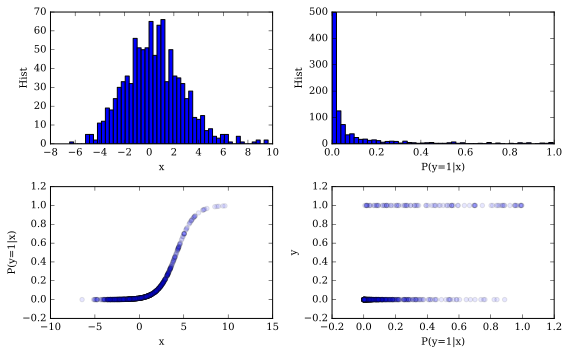

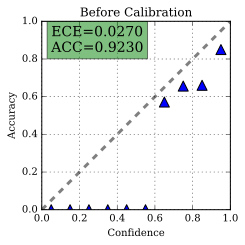

In [42]:
# generate simulation data
n = 1000
norm_params = np.array([[0, 2],
                        [4, 2]])
weights = np.array([0.9, 0.1])
x, y = gmm_sample(n, weights, norm_params) # (n, 1)
# compute posterior
# theta: np.array(n_components, n_samples). Each entry is P(x_i | component k) * weight_k
# posterior: np.array(n_samples, ). Each entry is f_x = P(y = 1|x).
theta = []
for (l, s), w in zip(norm_params, weights):
    theta.append(ss.norm.pdf(x, loc=l, scale=s) * w)
theta = np.array(theta)
f_x = theta[1]/(theta[0] + theta[1])

# plot the histogram of posterior
plt.subplot(2, 2, 1); plt.hist(x, bins=50)
plt.xlabel("x"); plt.ylabel("Hist")
plt.subplot(2, 2, 2); plt.hist(f_x, bins=50)
plt.xlabel("P(y=1|x)"); plt.ylabel("Hist")
plt.subplot(2, 2, 3); plt.scatter(x, f_x, alpha=0.1)
plt.xlabel("x"); plt.ylabel("P(y=1|x)")
plt.subplot(2, 2, 4); plt.scatter(f_x, y, alpha=0.1)
plt.xlabel("P(y=1|x)"); plt.ylabel("y")

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (3.5, 3.5))
ece, acc, ax = reliability_plot(ax, np.array([1-f_x, f_x]).T, y, 10)
ax.set_title("Before Calibration")
fig.tight_layout()

(1000,)


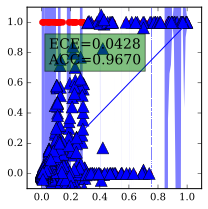

In [30]:
# fit GP to P(y=1|x) vs. y. (Subfigure 4)
f, ax = plt.subplots(1,1)
f.set_figheight(3)
f.set_figwidth(3)
ax = gp_regression(ax,f_x,y)
f.tight_layout()


Learned kernel: 1**2 * RBF(length_scale=1)

Learned kernel: RBF(length_scale=0.0654)

Learned kernel: RBF(length_scale=0.05) + 5.49**2 * RBF(length_scale=1.07)

Learned kernel: RBF(length_scale=0.05) + 3.39**2 * RBF(length_scale=1.43) + 6.5**2 * DotProduct(sigma_0=0.00271)

Learned kernel: 1**2 * RBF(length_scale=1)

Learned kernel: RBF(length_scale=0.0654)

Learned kernel: RBF(length_scale=0.385) + 3.97**2 * RBF(length_scale=0.161)

Learned kernel: RBF(length_scale=1) + 3.91**2 * RBF(length_scale=0.342) + 12.9**2 * DotProduct(sigma_0=0.436)


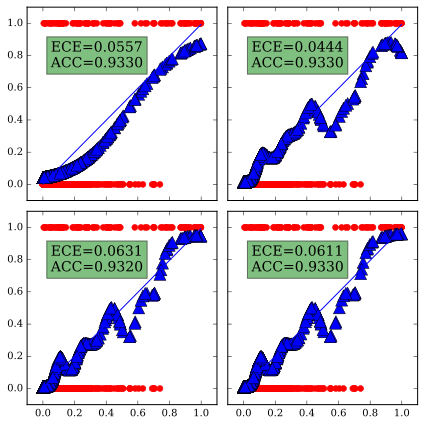

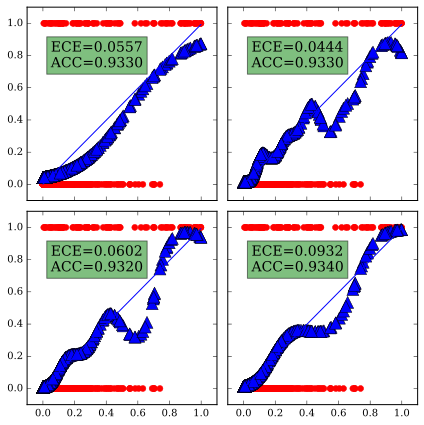

In [31]:
# GPC with sklearn
KERNELS = [None,
           RBF(0.1, (0.05, 1)), 
           RBF(0.1, (0.05, 1)) + 10**2 * RBF(1), 
           RBF(0.1, (0.05, 1)) + 10**2 * RBF(1) + 100.0 * DotProduct(sigma_0=1.0)]
f, ax = plt.subplots(2, 2, sharex='col', sharey='row')
f.set_figheight(6)
f.set_figwidth(6)
for i in range(len(KERNELS)):
    kernel = KERNELS[i]
    ax[i/2, i%2] = gpc_sklearn(ax[i/2, i%2],f_x,y,kernel)
f.tight_layout()


# GPC with sklearn
KERNELS = [None,
           RBF(1, (0.05, 1)), 
           RBF(1, (0.05, 1)) + 10**2 * RBF(1), 
           RBF(1, (0.05, 1)) + 10**2 * RBF(1) + 100.0 * DotProduct(sigma_0=1.0)]
f, ax = plt.subplots(2, 2, sharex='col', sharey='row')
f.set_figheight(6)
f.set_figwidth(6)
for i in range(len(KERNELS)):
    kernel = KERNELS[i]
    ax[i/2, i%2] = gpc_sklearn(ax[i/2, i%2],f_x,y,kernel)
f.tight_layout()


Name : gp_classification
Objective : 205.797332946
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |  value  |  constraints  |  priors
  rbf.variance        |    1.0  |      +ve      |        
  rbf.lengthscale     |    1.0  |      +ve      |         

iteration: 0 
Name : gp_classification
Objective : 191.438340659
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |                value  |  constraints  |  priors
  rbf.variance        |    2.355091107005066  |      +ve      |        
  rbf.lengthscale     |  0.15676862486000054  |      +ve      |        

iteration: 1 
Name : gp_classification
Objective : 189.645696947
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |               value  |  constraints  |  priors
  rbf.variance        |   3.902436318921354  |      +ve      |        
  rbf.lengths

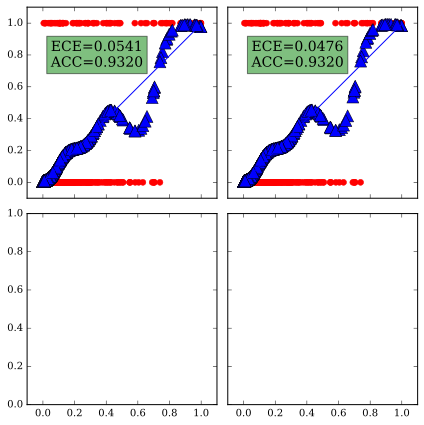

In [20]:
KERNELS = [None, 
           GPy.kern.RBF(1,variance=5.,lengthscale=0.1) + GPy.kern.Linear(1)]
f, ax = plt.subplots(2, 2, sharex='col', sharey='row')
f.set_figheight(6)
f.set_figwidth(6)
for i in range(len(KERNELS)):
    kernel = KERNELS[i]
    ax[i/2, i%2] = gpc_gpy(ax[i/2, i%2],f_x,y,kernel)
f.tight_layout()

# Take exponential of output probability

(1000,)


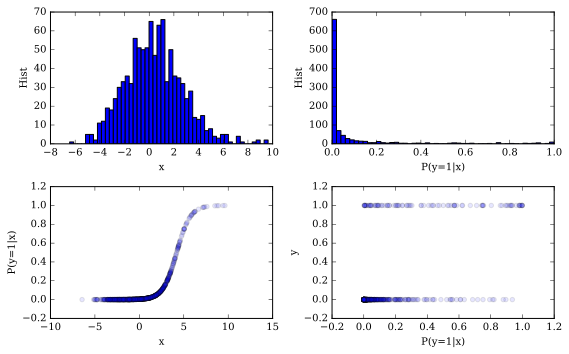

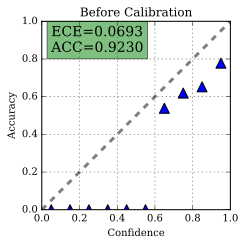

In [47]:
# generate simulation data
ALPHA = 1.3
p = np.array([1-f_x, f_x])
p_distort = p ** ALPHA
f_x_distort = p_distort[1]/(p_distort[0] + p_distort[1])
print f_x_distort.shape

# plot the histogram of posterior
plt.subplot(2, 2, 1); plt.hist(x, bins=50)
plt.xlabel("x"); plt.ylabel("Hist")
plt.subplot(2, 2, 2); plt.hist(f_x_distort, bins=50)
plt.xlabel("P(y=1|x)"); plt.ylabel("Hist")
plt.subplot(2, 2, 3); plt.scatter(x, f_x_distort, alpha=0.1)
plt.xlabel("x"); plt.ylabel("P(y=1|x)")
plt.subplot(2, 2, 4); plt.scatter(f_x_distort, y, alpha=0.1)
plt.xlabel("P(y=1|x)"); plt.ylabel("y")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (3.5, 3.5))
ece, acc, ax = reliability_plot(ax, np.array([1-f_x_distort, f_x_distort]).T, y, 10)
ax.set_title("Before Calibration")
fig.tight_layout()

(1000,)


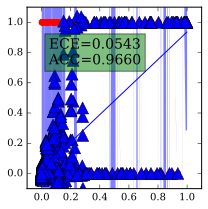

In [48]:
# fit GP to P(y=1|x) vs. y. (Subfigure 4)
f, ax = plt.subplots(1,1)
f.set_figheight(3)
f.set_figwidth(3)
ax = gp_regression(ax,f_x_distort,y)
f.tight_layout()


Learned kernel: 1**2 * RBF(length_scale=1)

Learned kernel: RBF(length_scale=0.0846)

Learned kernel: RBF(length_scale=0.0778) + 3.46**2 * RBF(length_scale=0.843)

Learned kernel: RBF(length_scale=0.0804) + 2.89**2 * RBF(length_scale=352) + 5.39**2 * DotProduct(sigma_0=0.0987)

Learned kernel: 1**2 * RBF(length_scale=1)

Learned kernel: RBF(length_scale=0.0846)

Learned kernel: RBF(length_scale=0.458) + 3**2 * RBF(length_scale=0.194)

Learned kernel: RBF(length_scale=1) + 1.29**2 * RBF(length_scale=0.128) + 5.99**2 * DotProduct(sigma_0=0.535)


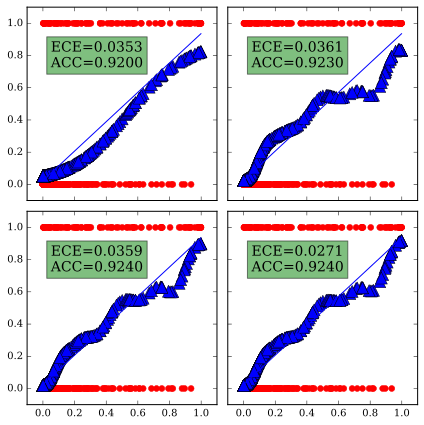

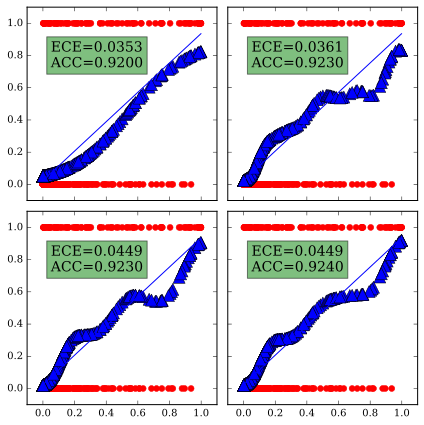

In [49]:
# GPC with sklearn
KERNELS = [None,
           RBF(0.1, (0.05, 1)), 
           RBF(0.1, (0.05, 1)) + 10**2 * RBF(1), 
           RBF(0.1, (0.05, 1)) + 10**2 * RBF(1) + 100.0 * DotProduct(sigma_0=1.0)]
f, ax = plt.subplots(2, 2, sharex='col', sharey='row')
f.set_figheight(6)
f.set_figwidth(6)
for i in range(len(KERNELS)):
    kernel = KERNELS[i]
    ax[i/2, i%2] = gpc_sklearn(ax[i/2, i%2],f_x_distort,y,kernel)
f.tight_layout()


# GPC with sklearn
KERNELS = [None,
           RBF(1, (0.05, 1)), 
           RBF(1, (0.05, 1)) + 10**2 * RBF(1), 
           RBF(1, (0.05, 1)) + 10**2 * RBF(1) + 100.0 * DotProduct(sigma_0=1.0)]
f, ax = plt.subplots(2, 2, sharex='col', sharey='row')
f.set_figheight(6)
f.set_figwidth(6)
for i in range(len(KERNELS)):
    kernel = KERNELS[i]
    ax[i/2, i%2] = gpc_sklearn(ax[i/2, i%2],f_x_distort,y,kernel)
f.tight_layout()


Name : gp_classification
Objective : 222.025497589
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |  value  |  constraints  |  priors
  rbf.variance        |    1.0  |      +ve      |        
  rbf.lengthscale     |    1.0  |      +ve      |         

iteration: 0 
Name : gp_classification
Objective : 211.270292524
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |               value  |  constraints  |  priors
  rbf.variance        |   6.612849388778439  |      +ve      |        
  rbf.lengthscale     |  0.4258587046074743  |      +ve      |        

iteration: 1 
Name : gp_classification
Objective : 211.005021953
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |               value  |  constraints  |  priors
  rbf.variance        |   7.978764694929144  |      +ve      |        
  rbf.lengthscal

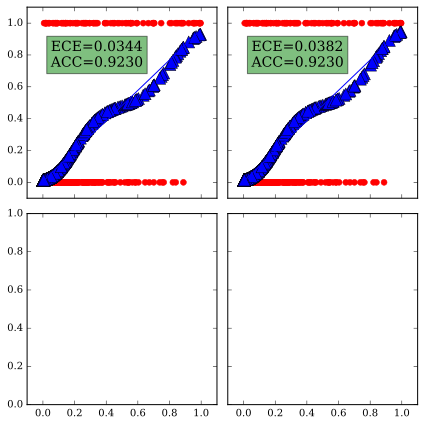

In [50]:
KERNELS = [None, 
           GPy.kern.RBF(1,variance=5.,lengthscale=0.1) + GPy.kern.Linear(1)]
f, ax = plt.subplots(2, 2, sharex='col', sharey='row')
f.set_figheight(6)
f.set_figwidth(6)
for i in range(len(KERNELS)):
    kernel = KERNELS[i]
    ax[i/2, i%2] = gpc_gpy(ax[i/2, i%2],f_x,y,kernel)
f.tight_layout(